In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import GainesSqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

unipolar
--- 0.34800004959106445 seconds ---
input error:  min: -0.00390625 , max: 0.0
output error: min: -0.07601457834243774 , max: 0.5
RMSE: 0.12683667931370612
MAE:  0.087165534
bias: 0.04993948


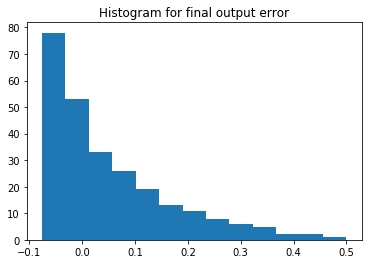

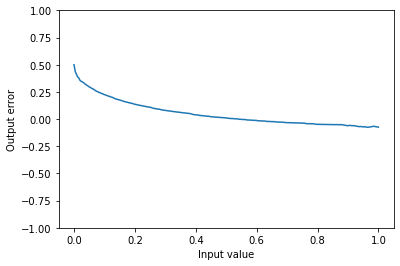

bipolar
--- 0.35699963569641113 seconds ---
input error:  min: 0.0 , max: 0.0
output error: min: -0.15545570850372314 , max: 0.4296875
RMSE: 0.1228121987064927
MAE:  0.10091136
bias: -0.018916937


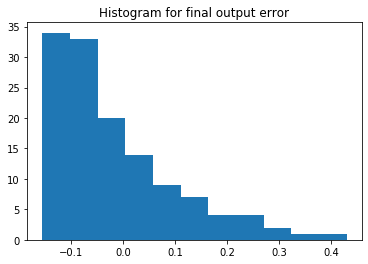

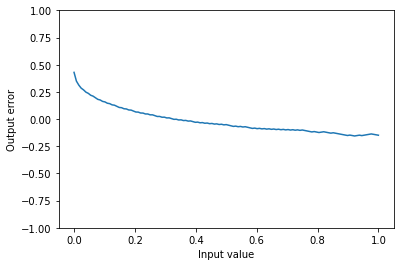

In [4]:
modes = ["unipolar", "bipolar"]
bitwidth = 8
depth=6
rng="Sobol"
rng_dim=2
bstype = torch.float
randtype = torch.float

for mode in modes:
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)

    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)
    
    dut_sqrt = GainesSqrt(depth=depth, mode=mode, rng=rng, rng_dim=rng_dim, bstype=bstype).to(device)
    
    output = torch.sqrt(input).to(device)
    outputPE = ProgressiveError(output, mode=mode).to(device)
    
    inputPE  = ProgressiveError(input,  mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            ouyput_bs = dut_sqrt(input_bs)   
            outputPE.Monitor(ouyput_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", "min:", torch.min(inputPE()[1]).item(), ", max:", torch.max(inputPE()[1]).item())
        # set invalid output statistics to special values
        print("output error:", "min:", torch.min(outputPE()[1]).item(), ", max:", torch.max(outputPE()[1]).item())
        
        #######################################################################
        # check the error distribution using histogram
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        result_pe = result_pe.flatten()
        print("RMSE:", math.sqrt(np.mean(result_pe**2)))
        print("MAE: ", np.mean(np.abs(result_pe)))
        print("bias:", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto', log=False)  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()
        
        #######################################################################
        # check the 3D plot contourf
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        fig = plt.figure()
        axis_len = outputPE()[1].size()[0]
        input_x_axis = []
        for axis_index in range(axis_len):
            input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        cs = plt.plot(input_x_axis, result_pe)
        plt.xlabel('Input value')
        plt.ylabel('Output error')
        plt.ylim(-1, 1)
        plt.show()